In [1]:
# Import necessary modules
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import numpy as np
import subprocess
import matplotlib.pyplot as plt



**Check the form of shapefile (point or line or polygon)**

In [ ]:


# Define the path to your shapefile
shapefile_path = '/Users/macbokpro/Desktop/AIS/cstlne_simple.shp'

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Print the first few rows to see the data
print(gdf.head())

# Check the geometry type of each feature
geometry_types = gdf.geom_type
print("Geometry types in the shapefile:")
print(geometry_types.value_counts())

# Print the unique geometry types
unique_geometry_types = gdf.geom_type.unique()
print(f"Unique geometry types: {unique_geometry_types}")

# Verify if all geometries are of a specific type
if all(gdf.geom_type == 'Polygon'):
    print("All geometries are polygons.")
elif all(gdf.geom_type == 'LineString'):
    print("All geometries are lines.")
elif all(gdf.geom_type == 'Point'):
    print("All geometries are points.")
else:
    print("The shapefile contains mixed geometry types.")


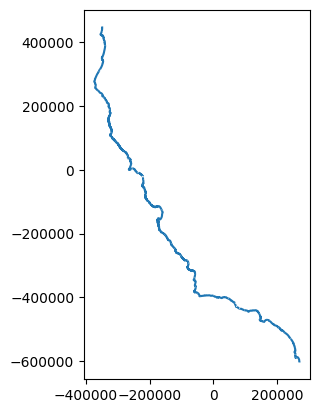

In [2]:
# Define static variables
CA_COASTLINE = "/Users/macbokpro/Desktop/AIS/cstlne_simple.shp"

# Define a function to read input arguments (adapted for notebook use)
def read_arg(input_file, output_file, grid_size=None):
    return input_file, output_file, grid_size

ca_coast = gpd.read_file(CA_COASTLINE)
ca_coast.plot()
plt.show()

**Create a buffer around the line shape file above (Line to polygon shapefile)**

In [3]:


# Read the line shapefile
line_coast = gpd.read_file('/Users/macbokpro/Desktop/AIS/cstlne_simple.shp')

# Create a buffer of 24 nautical miles (adjust the buffer distance as needed)
buffer_distance = 24 * 1852  # Convert nautical miles to meters if using a geographic CRS
polygon_coast = line_coast.buffer(buffer_distance)

# Convert the resulting geometry to a GeoDataFrame
polygon_coast_gdf = gpd.GeoDataFrame(geometry=polygon_coast, crs=line_coast.crs)

# Save the buffered polygons to a new shapefile
output_file = '/Users/macbokpro/Desktop/AIS/polygon_coastline.shp'
polygon_coast_gdf.to_file(output_file)

# Define static variables
CA_COASTLINE = "/Users/macbokpro/Desktop/AIS/polygon_coastline.shp"

# Define a function to read input arguments (adapted for notebook use)
def read_arg(input_file, output_file, grid_size=None):
    return input_file, output_file, grid_size

ca_coast = gpd.read_file(CA_COASTLINE)
ca_coast.plot()
plt.show()

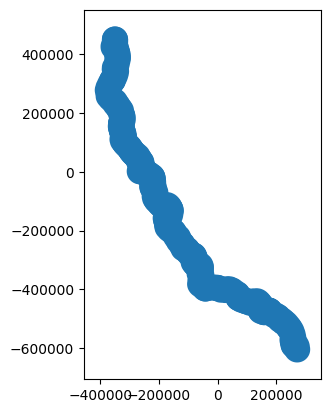

**Check the form of new buffer shapefile (point or line or polygon)**

In [7]:


# Define the path to your shapefile
shapefile_path = '/Users/macbokpro/Desktop/AIS/polygon_coastline.shp'

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Print the first few rows to see the data
print(gdf.head())

# Check the geometry type of each feature
geometry_types = gdf.geom_type
print("Geometry types in the shapefile:")
print(geometry_types.value_counts())

# Print the unique geometry types
unique_geometry_types = gdf.geom_type.unique()
print(f"Unique geometry types: {unique_geometry_types}")

# Verify if all geometries are of a specific type
if all(gdf.geom_type == 'Polygon'):
    print("All geometries are polygons.")
elif all(gdf.geom_type == 'LineString'):
    print("All geometries are lines.")
elif all(gdf.geom_type == 'Point'):
    print("All geometries are points.")
else:
    print("The shapefile contains mixed geometry types.")


   FID                                           geometry
0    0  POLYGON ((-393990.903 443423.731, -394056.418 ...
1    1  POLYGON ((-302359.241 384841.232, -302407.994 ...
2    2  POLYGON ((-386656.787 407127.821, -386635.226 ...
3    3  POLYGON ((-394308.277 352611.674, -394356.85 3...
4    4  POLYGON ((-394095.574 346832.733, -394099.472 ...
Geometry types in the shapefile:
Polygon         95
MultiPolygon     2
Name: count, dtype: int64
Unique geometry types: ['Polygon' 'MultiPolygon']
The shapefile contains mixed geometry types.


**AIS data CSV fiel to shape file & spatial join with coastline shape file**

In [8]:
# Function to convert CSV to point shapefile
def csv_to_point(input_file, output_file):
    # Read input csv file as a pandas dataframe with low memory option to handle mixed data types
    df = pd.read_csv(input_file, on_bad_lines='skip', low_memory=False)

    # Check the initial DataFrame
    print("Initial DataFrame head:")
    print(df.head())
    print("Initial DataFrame shape:", df.shape)

    # Convert dataframe to geodataframe using LAT and LON fields
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.LON, df.LAT, crs="EPSG:4326"))

    # Check the converted GeoDataFrame
    print("Converted GeoDataFrame head:")
    print(gdf.head())
    print("Converted GeoDataFrame shape:", gdf.shape)

    # Read CA coastline file
    ca_coast = gpd.read_file(CA_COASTLINE)
    print("CA Coastline GeoDataFrame head:")
    print(ca_coast.head())
    print("CA Coastline GeoDataFrame shape:", ca_coast.shape)

    # Ensure the CRS of the CA coastline is compatible
    ca_coast = ca_coast.to_crs(epsg=4326)

    # Intersect AIS points with CA Coastline
    gdf = gpd.sjoin(gdf, ca_coast, how="inner", predicate='within')

    # Check the result of the spatial join
    print("GeoDataFrame after spatial join head:")
    print(gdf.head())
    print("GeoDataFrame after spatial join shape:", gdf.shape)

    if gdf.empty:
        print("No points within the CA coastline. Check the input data and the CA coastline shapefile.")

    # Rename columns to be within 10 characters for shapefile compatibility
    gdf.rename(columns={
        'BaseDateTime': 'BaseDateTi',
        'TransceiverClass': 'Transceive',
        'index_right': 'index_righ',
        'LENGTH': 'LENGTH_1'
    }, inplace=True)

    # Output geodataframe to shapefile
    gdf.to_file(output_file)

# Example
input_file = 'AIS_2019_12:29_1:29.csv'
point_output_file = 'points.shp'

# Step 1: Convert CSV to Point Shapefile
csv_to_point(input_file, point_output_file)


Initial DataFrame head:
        MMSI         BaseDateTime       LAT        LON   SOG    COG  Heading  \
0  368064650  2020-01-01T00:00:00  33.72365 -118.27967   0.0  360.0    511.0   
1    3669999  2020-01-01T00:00:01  33.72340 -118.28068   0.1  258.5    511.0   
2  367661930  2020-01-01T00:00:02  33.72981 -118.27564   0.1  301.7    511.0   
3  368024740  2020-01-01T00:00:03  33.72909 -118.18749  16.7   85.0     81.0   
4  248951000  2020-01-01T00:00:03  33.68217 -118.20249   9.3  198.7    201.0   

       VesselName         IMO CallSign  VesselType  Status  Length  Width  \
0             NaN         NaN      NaN         NaN    15.0     NaN    NaN   
1             NaN         NaN      NaN         NaN     0.0     NaN    NaN   
2  MICHELLE SLOAN  IMO9747819  WDH8832        31.0     0.0    24.0    NaN   
3             NaN         NaN      NaN         NaN    15.0     NaN    NaN   
4             NaN         NaN      NaN         NaN     0.0     NaN    NaN   

   Draft  Cargo TransceiverClass

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pyogrio/raw.py:709: RuntimeWarning: 2GB file size limit reached for points.dbf. Going on, but might cause compatibility issues with third party software
  ogr_write(


In [9]:
    # Read input shapefile
    gdf_point = gpd.read_file(point_output_file)

    # Print and visualize the input GeoDataFrame
    print(gdf_point.head())

        MMSI           BaseDateTi       LAT        LON  SOG    COG  Heading  \
0  368064650  2020-01-01T00:00:00  33.72365 -118.27967  0.0  360.0    511.0   
1  368064650  2020-01-01T00:00:00  33.72365 -118.27967  0.0  360.0    511.0   
2  368064650  2020-01-01T00:00:00  33.72365 -118.27967  0.0  360.0    511.0   
3  368064650  2020-01-01T00:00:00  33.72365 -118.27967  0.0  360.0    511.0   
4  368064650  2020-01-01T00:00:00  33.72365 -118.27967  0.0  360.0    511.0   

  VesselName   IMO CallSign  VesselType  Status  Length  Width  Draft  Cargo  \
0       None  None     None         NaN    15.0     NaN    NaN    NaN    NaN   
1       None  None     None         NaN    15.0     NaN    NaN    NaN    NaN   
2       None  None     None         NaN    15.0     NaN    NaN    NaN    NaN   
3       None  None     None         NaN    15.0     NaN    NaN    NaN    NaN   
4       None  None     None         NaN    15.0     NaN    NaN    NaN    NaN   

  Transceive  index_righ  FID               

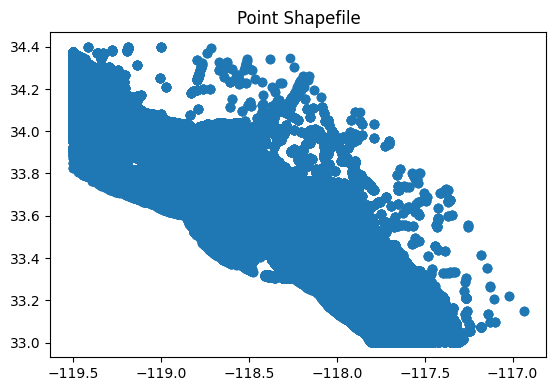

In [10]:
# plot to visualize
gdf_point.plot()
plt.title('Point Shapefile')
plt.show()

**convert point shape file to line shape file to track the trajectories for each vessel**

In [11]:
# Function to convert point shapefile to line shapefile
def point_to_line(input_file, output_file):
    # Read input shapefile
    gdf_point = gpd.read_file(input_file)

    # Sort dataframe by MMSI and BaseDateTime
    gdf_point = gdf_point.sort_values(by=['MMSI', 'BaseDateTi']) 
    gdf_point = gdf_point.reset_index(drop=True)

    # Convert to MM5 projection
    gdf_point = gdf_point.to_crs('+proj=lcc +lat_1=30 +lat_2=60 +lat_0=37 +lon_0=120.5W +x_0=0 +y_0=0 +ellps=clrk66 +units=m +no_defs +a=6370000.0 +b=6370000.0')    

    # Calculate distance between consecutive points
    gdf_point1 = gdf_point.shift(1)
    gdf_point1 = gdf_point1.set_crs(gdf_point.crs)
    gdf_point['distance_from_previous'] = gdf_point.distance(gdf_point1)    
    gdf_point.loc[0, 'distance_from_previous'] = 0

    # Calculate previous MMSI for each point
    gdf_point1.loc[0,'MMSI'] = 0
    gdf_point['previous_mmsi'] = gdf_point1['MMSI'].astype(int)

    # Convert distance to miles
    gdf_point['distance_from_previous'] = gdf_point['distance_from_previous'] * 0.000621371

    # Find split points for lines
    gdf_point['split'] = ''
    gdf_point.loc[(gdf_point['distance_from_previous'] > 1), 'split'] = 'S'
    gdf_point.loc[(gdf_point['MMSI'] != gdf_point['previous_mmsi']), 'split'] = 'S'

    # Create unique ID's for splits
    gdf_point['UID'] = 0
    uid = 1
    last_split = 0
    for i in range(len(gdf_point['split'])):
        if gdf_point['split'][i] == 'S':
            gdf_point.loc[last_split:i, 'UID'] = uid
            uid += 1
            last_split = i

    # Group points into lines based on MMSI and max distance of 1 mile
    gdf_line = gdf_point.groupby(['MMSI', 'UID'])['geometry'].apply(lambda x: LineString(x.tolist()) if x.size > 1 else None)
    gdf_line = gpd.GeoDataFrame(gdf_line, geometry='geometry')
    gdf_line.crs = gdf_point.crs

    # Write output file
    gdf_line.to_file(output_file)


In [ ]:
# Call the function in a notebook cell
input_point_file = 'points.shp'  # Path to the input point shapefile generated in Step 1
line_output_file = 'lines.shp'  # Path to the output line shapefile

# Step 2: Convert Point Shapefile to Line Shapefile
point_to_line(input_point_file, line_output_file)

Line Shapefile Head:
      MMSI  UID                                           geometry
0  3669999    2  LINESTRING (202268.421 -354483.798, 202268.421...
1  3669999    3  LINESTRING (215980.926 -353071.09, 215980.926 ...
2  3669999    4  LINESTRING (204391.892 -355548.4, 203641.621 -...
3  3669999    5  LINESTRING (205214.905 -349956.081, 205391.916...
4  3669999    6  LINESTRING (202630.893 -352531.069, 202627.598...
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",37],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Number of lines: 5863


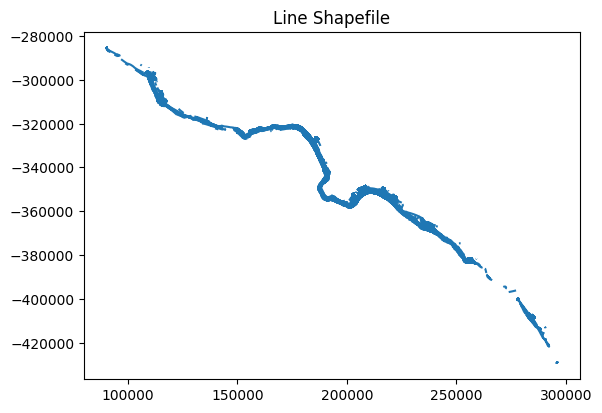

In [24]:
# Load the generated line shapefile to check the output
gdf_line = gpd.read_file(line_output_file)

# Print the head of the GeoDataFrame
print("Line Shapefile Head:")
print(gdf_line.head())

# Check the Coordinate Reference System (CRS)
print("CRS:", gdf_line.crs)

# Count the number of lines
print("Number of lines:", len(gdf_line))

# plot the lines to visualize them
gdf_line.plot()
plt.title('Line Shapefile')
plt.show()

**Convert line shapefile to gridded polygon shapefile to get the counts in each grid to track vessel activity in areas**

In [27]:
# Function to convert line shapefile to gridded polygon shapefile
def line_to_grid(input_file, output_file, grid_size):
    # Create temporary processing directory
    os.makedirs('./tmp/', exist_ok=True)

    # Read input file to geodataframe
    gdf = gpd.read_file(input_file)

    # Filter out bad lines
    gdf = gdf[gdf.geometry.type == 'LineString']
    gdf['Count'] = 1

    # Check if the GeoDataFrame is empty after filtering
    if gdf.empty:
        raise ValueError("No valid LineString geometries found in the input file.")

    # Write lines to temporary shapefile
    gdf.to_file('./tmp/lines.shp')

    # Get bounding coordinates
    x0, y0, x1, y1 = gdf.geometry.total_bounds
    if any(pd.isna([x0, y0, x1, y1])):
        raise ValueError("Invalid bounding box coordinates. Ensure the input data contains valid geometries.")

    print(f"Bounding Box: x0={x0}, y0={y0}, x1={x1}, y1={y1}")

    # Convert lines to raster grid count
    rasterize_cmd = f'gdal_rasterize -te {x0} {y0} {x1} {y1} -tr {grid_size} {grid_size} -ot Float32 -of GTiff -a COUNT -init 0.0 -add -l lines ./tmp/lines.shp ./tmp/grid.tif'
    print(f"Running command: {rasterize_cmd}")
    subprocess.run(rasterize_cmd, shell=True, check=True)

    # Check if grid.tif was created
    if not os.path.exists('./tmp/grid.tif'):
        raise FileNotFoundError("Failed to create grid.tif. Check GDAL installation and input data.")

    # Convert raster to polygon
    polygonize_cmd = 'gdal_polygonize.py ./tmp/grid.tif -b 1 ./tmp/grid_poly.shp poly grid_count'
    print(f"Running command: {polygonize_cmd}")
    subprocess.run(polygonize_cmd, shell=True, check=True)

    # Check if grid_poly.shp was created
    if not os.path.exists('./tmp/grid_poly.shp'):
        raise FileNotFoundError("Failed to create grid_poly.shp. Check GDAL installation and input data.")

    # Read polygons file as geodataframe
    gdf = gpd.read_file('./tmp/grid_poly.shp')

    # Filter out zero values from polygons
    gdf = gdf[gdf['grid_count'] > 0]

    # Transform gdf to MM5
    gdf = gdf.to_crs('+proj=lcc +lat_1=30 +lat_2=60 +lat_0=37 +lon_0=-120.5 +x_0=0 +y_0=0 +ellps=clrk66 +units=m +no_defs +a=6370000.0 +b=6370000.0')

    # Write output file
    gdf.to_file(output_file)

    # Remove temporary processing directory
    os.system('rm -r ./tmp/')

In [29]:
#call the function in a notebook cell
line_output_file = 'lines.shp'  # Path to the output line shapefile
grid_output_file = 'AIS_2019_12:29_1:29_grid.shp'
grid_size = 100

# Step 3: Convert Line Shapefile to Gridded Polygon Shapefile
line_to_grid(line_output_file, grid_output_file, grid_size)

Bounding Box: x0=90269.0324135607, y0=-429521.1049566236, x1=296115.2570840811, y1=-285339.8786718616
Running command: gdal_rasterize -te 90269.0324135607 -429521.1049566236 296115.2570840811 -285339.8786718616 -tr 100 100 -ot Float32 -of GTiff -a COUNT -init 0.0 -add -l lines ./tmp/lines.shp ./tmp/grid.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Running command: gdal_polygonize.py ./tmp/grid.tif -b 1 ./tmp/grid_poly.shp poly grid_count



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/bin/gdal_polygonize.py", line 12, in <module>
    sys.exit(main(sys.argv))
  File "/usr/local/lib/python3.12/site-packages/osgeo_utils/gdal_polygonize.py", line 359, in main
    return GDALPolygonize().main(argv)
  File "/usr/local/lib/python3.12/site-packages/osgeo_utils/auxiliary/gdal_argparse.py", line 229, in main
    self.doit(**kwargs)
  File "/usr/local/lib/python3.12/site-packages/osgeo_utils/gdal_polygonize.py", line 355, in doit
    return gdal_polygonize(**kwargs)
  File "/usr/local/lib/python

Creating output ./tmp/grid_poly.shp of format ESRI Shapefile.
0...10...20...30...40...50...60...70...80...90...100 - done.



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/usr/local/bin/gdal_polygonize.py", line 12, in <module>
    sys.exit(main(sys.argv))
  File "/usr/local/lib/python3.12/site-packages/osgeo_utils/gdal_polygonize.py", line 359, in main
    return GDALPolygonize().main(argv)
  File "/usr/local/lib/python3.12/site-packages/osgeo_utils/auxiliary/gdal_argparse.py", line 229, in main
    self.doit(**kwargs)
  File "/usr/local/lib/python3.12/site-packages/osgeo_utils/gdal_polygonize.py", line 355, in doit
    return gdal_polygonize(**kwargs)
  File "/usr/local/lib/python

Grid Shapefile Head:
   grid_count                                           geometry
0           1  POLYGON ((90369.032 -285339.879, 90469.032 -28...
1           3  POLYGON ((90269.032 -285339.879, 90369.032 -28...
2           2  POLYGON ((90369.032 -285439.879, 90469.032 -28...
3           1  POLYGON ((90269.032 -285539.879, 90369.032 -28...
4           1  POLYGON ((90469.032 -285639.879, 90569.032 -28...
CRS: PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",37],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Number of grid polygons: 18558


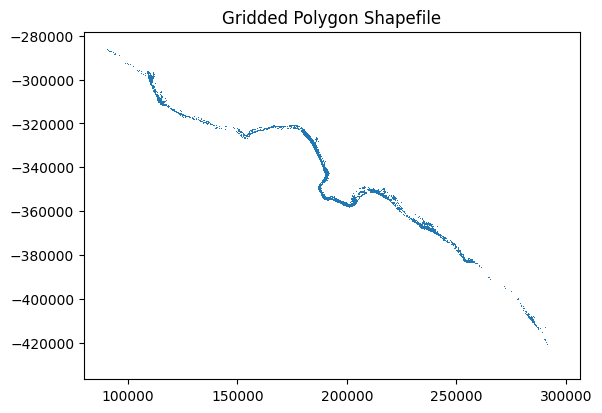

In [31]:
# Load the generated grid shapefile to check the output
gdf_grid = gpd.read_file(grid_output_file)

# Print the head of the GeoDataFrame
print("Grid Shapefile Head:")
print(gdf_grid.head())

# Check the Coordinate Reference System (CRS)
print("CRS:", gdf_grid.crs)

# Count the number of polygons
print("Number of grid polygons:", len(gdf_grid))

# Optionally, plot the grid to visualize it
gdf_grid.plot()
plt.title('Gridded Polygon Shapefile')
plt.show()


**Checck the output and perform analysis on the output**

In [32]:
# Load the gridded shapefile
grid_output_file = 'AIS_2019_12:29_1:29_grid.shp'
gdf_grid = gpd.read_file(grid_output_file)

# Check the first few rows
print(gdf_grid.head())
print(gdf_grid.crs)
print("Number of grid polygons:", len(gdf_grid))

   grid_count                                           geometry
0           1  POLYGON ((90369.032 -285339.879, 90469.032 -28...
1           3  POLYGON ((90269.032 -285339.879, 90369.032 -28...
2           2  POLYGON ((90369.032 -285439.879, 90469.032 -28...
3           1  POLYGON ((90269.032 -285539.879, 90369.032 -28...
4           1  POLYGON ((90469.032 -285639.879, 90569.032 -28...
PROJCS["unknown",GEOGCS["unknown",DATUM["unknown",SPHEROID["unknown",6370000,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",37],PARAMETER["central_meridian",-120.5],PARAMETER["standard_parallel_1",30],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Number of grid polygons: 18558


In [34]:
# Print the columns of the GeoDataFrame
print("Columns in the shapefile:")
print(gdf.columns)

Columns in the shapefile:
Index(['FID', 'geometry'], dtype='object')


In [33]:
# Calculate areas of grid cells
gdf_grid['area'] = gdf_grid.geometry.area
print(gdf_grid[['geometry', 'area']].head())

                                            geometry     area
0  POLYGON ((90369.032 -285339.879, 90469.032 -28...  10000.0
1  POLYGON ((90269.032 -285339.879, 90369.032 -28...  20000.0
2  POLYGON ((90369.032 -285439.879, 90469.032 -28...  20000.0
3  POLYGON ((90269.032 -285539.879, 90369.032 -28...  20000.0
4  POLYGON ((90469.032 -285639.879, 90569.032 -28...  30000.0


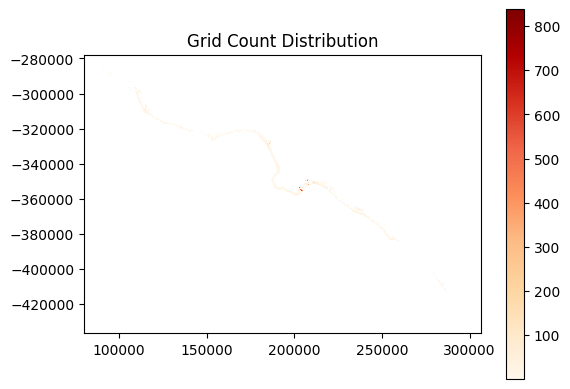

In [35]:
import matplotlib.pyplot as plt

gdf_grid.plot(column='grid_count', cmap='OrRd', legend=True)
plt.title('Grid Count Distribution')
plt.show()
